# Quanvolutional Neural Networks

QNN для распознавания картинок на основе [туториала](https://pennylane.ai/qml/demos/tutorial_quanvolution.html)

In [34]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Задаём константы, которые пригодятся нам в будущем

In [35]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 500    # Size of the train dataset
n_test = 300   # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


Загружаем датасет MNIST:

In [36]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

In [37]:
len(train_labels)

60000

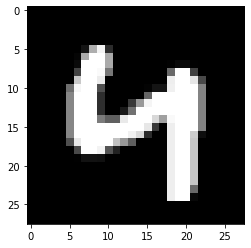

In [38]:
plt.imshow(train_images[222], cmap="gray")

Датасет достаточно большой, для работы возьмём малую его часть

In [39]:
# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

Нормализуем картинки, так как каждый пиксель закодирован значением от 0 до 255

In [40]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

Добавляем ещё одно измерение

In [41]:
# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [42]:
train_images.shape

(500, 28, 28, 1)

## Квантовая свёртка

Зададим ядро свёртку в виде квантовой схемы

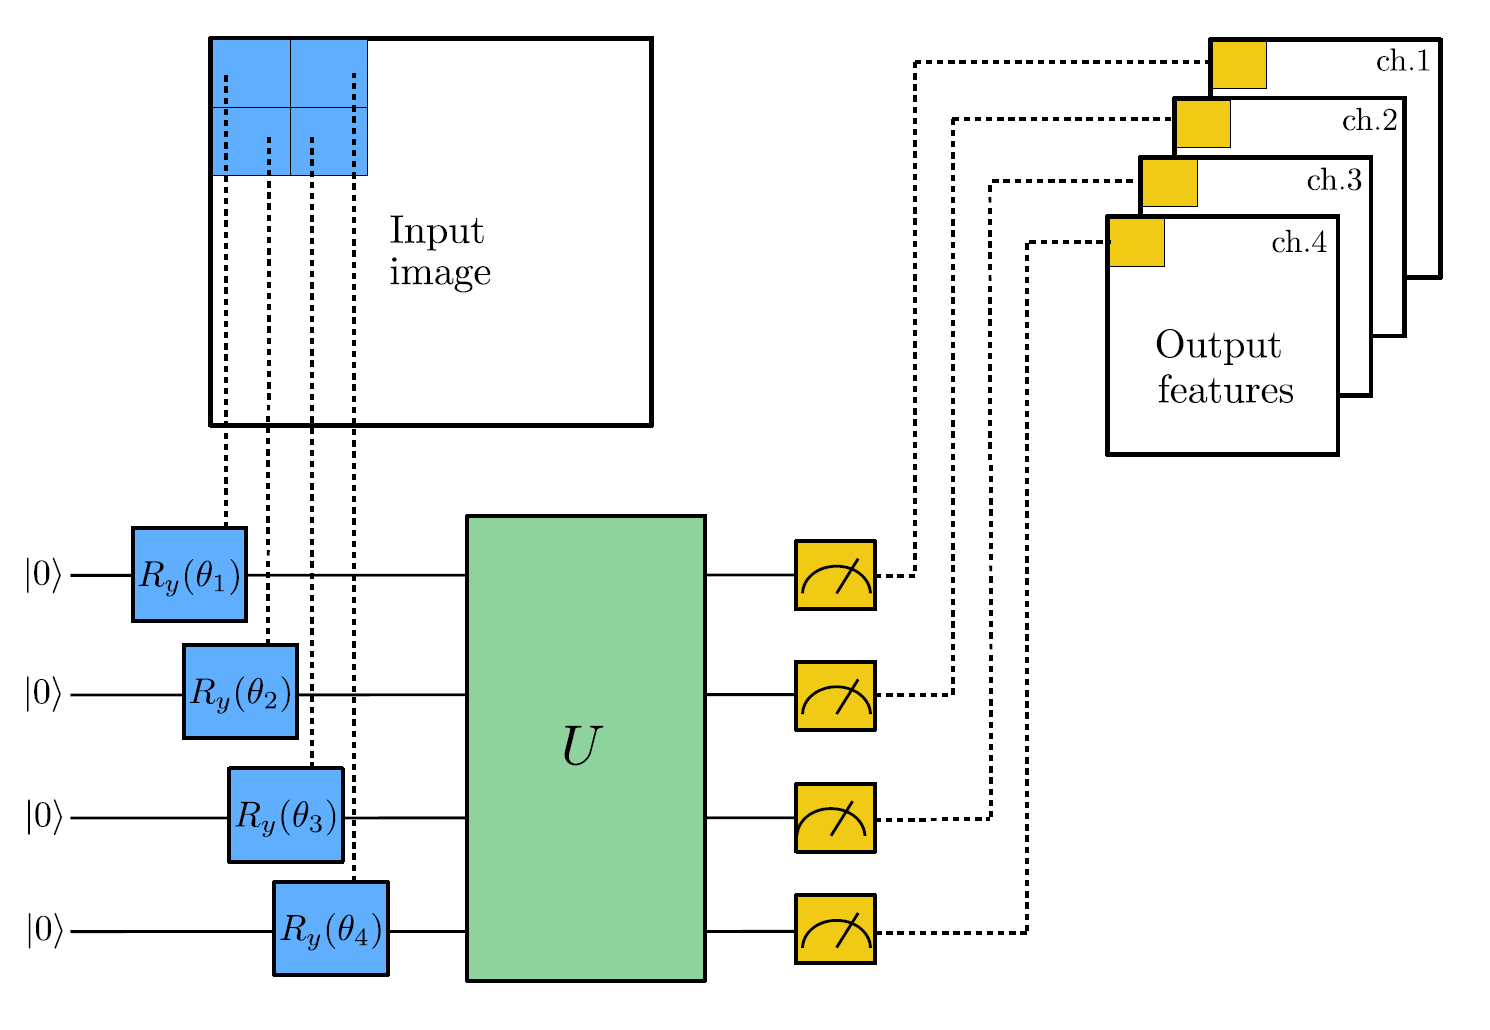

Инициализируем девайс с 4-мя кубитами

In [43]:
dev = qml.device("default.qubit", wires=4)

а также случаные параметры $\theta_i$

In [44]:
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
rand_params

tensor([[3.44829694, 4.49366732, 3.78727399, 3.42360201]], requires_grad=True)

Теперь построим простую схему, которая станет квантовым свёрточным слоем. К каждому квадратику $2 \times 2$ применяется квантовая схема, в которой мы "поворачиваем" соответствующий кубит по оси $Y$ 

In [45]:
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Обернём применение квантовой схемы в функцию `quanv`, которая будет применять операцию свёртки ко всему изображению

In [46]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [47]:
quanv(train_images[0]).shape

(14, 14, 4)

## Подготовка датасета

Так как квантовая свёртка "заморожена" и не обучается в процессе, удобно сразу применить её к изображениям на шаге предобработки

In [48]:
if PREPROCESS == True:
    # q_train_images = []
    # print("Quantum pre-processing of train images:")
    # for idx, img in enumerate(train_images):
    #     print("{}/{}        ".format(idx + 1, n_train), end="\r")
    #     q_train_images.append(quanv(img))
    # q_train_images = np.asarray(q_train_images)
    # # Save pre-processed images
    # np.save(SAVE_PATH + "q_train_images.npy", q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Quantum pre-processing of test images:


Теперь можно увидеть, что с нашими картинками сделала квнтовая свёртка:

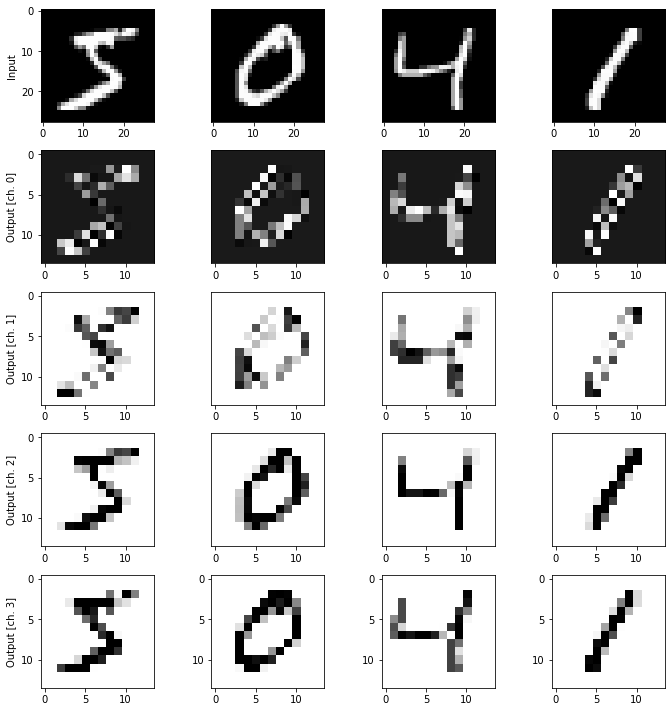

In [52]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")
plt.tight_layout()
plt.show()

## Обучаем гибридную сеть

Теперь, после обработки квантовой свёртки, добавим полносвязный классически слой, чтобы натренировать классификатор

In [53]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [54]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

2021-12-16 22:13:24.711265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 22:13:25.073124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib
2021-12-16 22:13:25.122147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib
2021-12-16 22:13:25.122213: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guid

Epoch 1/30
125/125 - 2s - loss: 1.8471 - accuracy: 0.3960 - val_loss: 1.3528 - val_accuracy: 0.5367 - 2s/epoch - 19ms/step
Epoch 2/30
125/125 - 0s - loss: 0.8580 - accuracy: 0.7640 - val_loss: 0.9807 - val_accuracy: 0.6767 - 179ms/epoch - 1ms/step
Epoch 3/30
125/125 - 0s - loss: 0.5783 - accuracy: 0.8300 - val_loss: 0.8562 - val_accuracy: 0.6967 - 159ms/epoch - 1ms/step
Epoch 4/30
125/125 - 0s - loss: 0.4443 - accuracy: 0.8880 - val_loss: 0.7572 - val_accuracy: 0.7567 - 156ms/epoch - 1ms/step
Epoch 5/30
125/125 - 0s - loss: 0.3638 - accuracy: 0.9120 - val_loss: 0.6659 - val_accuracy: 0.7767 - 170ms/epoch - 1ms/step
Epoch 6/30
125/125 - 0s - loss: 0.2812 - accuracy: 0.9400 - val_loss: 0.6311 - val_accuracy: 0.7867 - 153ms/epoch - 1ms/step
Epoch 7/30
125/125 - 0s - loss: 0.2347 - accuracy: 0.9560 - val_loss: 0.5863 - val_accuracy: 0.8200 - 159ms/epoch - 1ms/step
Epoch 8/30
125/125 - 0s - loss: 0.2039 - accuracy: 0.9540 - val_loss: 0.5610 - val_accuracy: 0.8067 - 156ms/epoch - 1ms/step
Ep

А теперь попробуем обучить модельку без слоя квантовой свёртки

In [55]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
125/125 - 0s - loss: 1.6251 - accuracy: 0.5520 - val_loss: 1.3071 - val_accuracy: 0.6667 - 469ms/epoch - 4ms/step
Epoch 2/30
125/125 - 0s - loss: 0.8214 - accuracy: 0.8200 - val_loss: 0.9721 - val_accuracy: 0.7367 - 149ms/epoch - 1ms/step
Epoch 3/30
125/125 - 0s - loss: 0.5835 - accuracy: 0.8640 - val_loss: 0.8235 - val_accuracy: 0.7733 - 171ms/epoch - 1ms/step
Epoch 4/30
125/125 - 0s - loss: 0.4586 - accuracy: 0.8880 - val_loss: 0.7115 - val_accuracy: 0.8200 - 159ms/epoch - 1ms/step
Epoch 5/30
125/125 - 0s - loss: 0.3842 - accuracy: 0.9100 - val_loss: 0.6515 - val_accuracy: 0.8467 - 172ms/epoch - 1ms/step
Epoch 6/30
125/125 - 0s - loss: 0.3268 - accuracy: 0.9240 - val_loss: 0.6063 - val_accuracy: 0.8433 - 164ms/epoch - 1ms/step
Epoch 7/30
125/125 - 0s - loss: 0.2857 - accuracy: 0.9480 - val_loss: 0.5588 - val_accuracy: 0.8600 - 156ms/epoch - 1ms/step
Epoch 8/30
125/125 - 0s - loss: 0.2513 - accuracy: 0.9460 - val_loss: 0.5312 - val_accuracy: 0.8633 - 160ms/epoch - 1ms/step


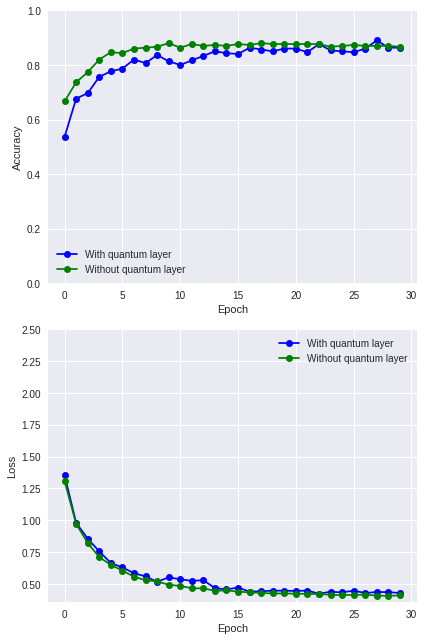

In [56]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()